In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plumed
import lammps_logfile
import warnings
warnings.filterwarnings("ignore")

from lmp_spc_scripts import read_xyz_traj,xyz_cords_array,parse_lammpstrj

This notebook provides instructions to how the configurations of alanine dipeptifde (ADP) were selected fro the SpecialCases:Unbias distributions for 500, 1000 and 2500 samples. 

In [2]:
# Load colvars
colvar_gt=plumed.read_as_pandas("./colvar_multi_0.dat")

# Separate varaibles
time = colvar_gt["time"]/10e2
phi = colvar_gt["phi"]
psi = colvar_gt["psi"]

In [4]:
# ## OPTIONAL: Uncomment to plot all sampled variables 

# # Load colvar.dat file and plot phi and psi as a function of time


# plt.plot(time,phi,"x",label="phi",alpha=0.99)
# plt.plot(time,psi,"x",label="psi",alpha=0.99)
# #plt.plot(colvar_gt.time,colvar_gt.psi,"x",label="psi",alpha=0.5)
# plt.xlabel("Time (ns)",fontsize=14)
# plt.ylabel("phi (rad)",fontsize=14)
# plt.legend(fontsize=12,loc="center right")
# plt.show()

# plt.plot(phi,psi,"x")
# plt.title('CV Sampled Space',fontsize=14,fontweight='bold')
# plt.xlabel("$\phi$ (rad)",fontsize=14)
# plt.ylabel("$\psi$ (rad)",fontsize=14)
# plt.xlim((-np.pi,np.pi))
# plt.ylim((-np.pi,np.pi))
# plt.show()




In [5]:
# Convert to pandas dataframe
import pandas as pd
selected_phi_psi = pd.DataFrame(np.array((np.arange(0,len(phi),1),phi,psi)).T, columns=['index','phi', 'psi'])


In [23]:
## Define function to select m samples from a dataframe following the underlying distribution

def select_uniform_rows(df, m, seed=None):
    if seed is not None:
        np.random.seed(seed)  # Set seed for reproducibility

    n = len(df)  # Number of rows in the DataFrame
    indices = np.random.choice(n, size=m, replace=False)
    selected_rows = df.iloc[indices]

    # Store indices in an array and save to a file
    indices_array = np.array(indices)
    np.save('selected_indices_Unif.npy', indices_array)  # Save indices to a file

    with open('selected_indices.txt', 'w') as file:
        file.write('Selected Indices:\n')
        for index in indices:
            file.write(f'{index}\n')  # Write indices to a text file

    return selected_rows, indices_array # Return inidices 


Redefine the number of samples (m) to be selected 


In [24]:

# Example usage:
n = len(selected_phi_psi)  # Number of rows in the DataFrame
m = 500   # Number of rows to select uniformly
#m = 1000
#m = 25000
seed = 54168  # Seed for reproducibility

selected_rows, indices = select_uniform_rows(selected_phi_psi, m, seed)
print("Selected Rows lenght:")
print(len(selected_rows))
#print("Indices Array:")
#print(indices)


Selected Rows lenght:
500


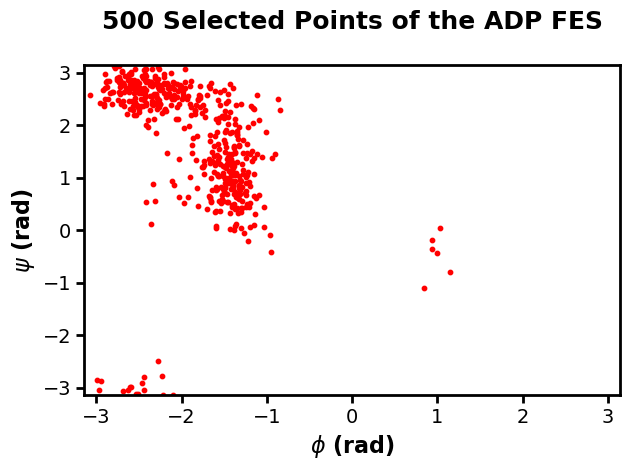

In [25]:
## PLot the selected samples
phi_select = selected_rows['phi']
psi_select = selected_rows['psi']
## Scatter plot of phi,psi combinations

plt.scatter(phi_select,psi_select,marker='o',c='r',s=10)
# plt.scatter(extra_phi,extra_psi,marker='o',c='r',s=10)
    
ax = plt.gca()
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
plt.tick_params(axis='both', which='major', labelsize=14, width=2, length=6)
plt.title(f'{len(phi_select)} Selected Points of the ADP FES\n',fontsize=18,fontweight="bold")
plt.xlabel("$\phi$ (rad)",fontsize=16,fontweight="bold")
plt.ylabel("$\psi$ (rad)",fontsize=16,fontweight="bold")
plt.xlim((-np.pi,np.pi))
plt.ylim((-np.pi,np.pi))

plt.tight_layout()
plt.show()

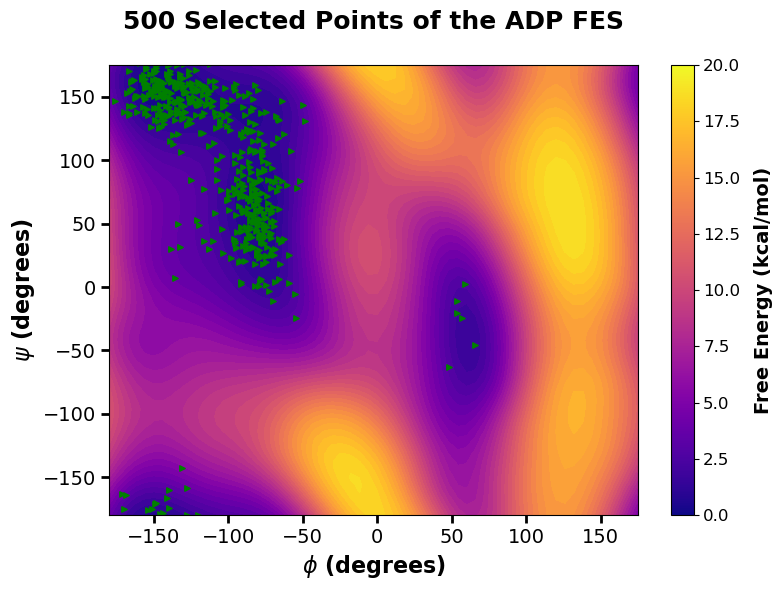

In [26]:
## PLot selected points on top of ADP FES data
# Load the FES data
fes = np.loadtxt("ADP_CLC_FES_Metadym.dat")

# Extract the phi, psi, and FES values
phi = np.rad2deg(fes[:, 0])
psi = np.rad2deg(fes[:, 1])
fes_values = fes[:, 2]

# Reshape the FES values into a grid
nbins_phi = len(np.unique(phi))
nbins_psi = len(np.unique(psi))
fes_grid = fes_values.reshape(nbins_phi, nbins_psi)

# Create meshgrid for phi and psi
phi_grid, psi_grid = np.meshgrid(np.unique(phi), np.unique(psi))

# Convert the energy to kcal/mol
fes_grid_kcal = fes_grid * 0.239

plt.figure(figsize=(8, 6))
plt.rcParams['axes.facecolor'] = 'white'
plt.tick_params(axis='both', which='major', labelsize=14, width=2, length=6)
# Plot the FES as a surface or grid with modified color scale
plt.pcolormesh(phi_grid, psi_grid, fes_grid_kcal, cmap='plasma', shading='nearest', vmin=0, vmax=20)
# plt.colorbar(label="Free Energy (kcal/mol)", ticks=np.arange(0, 21, 5))

cbar = plt.colorbar(label="Free Energy (kcal/mol)")
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_ylabel('Free Energy (kcal/mol)', fontsize=14, labelpad=10,fontweight="bold")

plt.xlim(-180,175)
plt.ylim(-180,175)

plt.xlabel("$\phi$ (degrees)", fontsize=16, fontweight='bold')
plt.ylabel("$\psi$ (degrees)", fontsize=16, fontweight='bold')
#plt.title("Alanine Dipeptide FES\n", fontsize=18, fontweight='bold')
plt.title(f'{len(phi_select)} Selected Points of the ADP FES\n',fontsize=18,fontweight="bold")

# Add contour lines every 2.5 kcal/mol
contour_levels = np.arange(0, 20, 0.5)
plt.contourf(phi_grid, psi_grid, fes_grid_kcal, levels=contour_levels,cmap='plasma')
plt.scatter(np.rad2deg(phi_select),np.rad2deg(psi_select),marker='>',c='green',s=15)
# save
# plt.savefig('ADP_REF_fes.png', dpi=400, bbox_inches='tight')
plt.tight_layout()
plt.show()


The indices of the configurations of interest have been stored inthe indices array and can be used now to recover the potential energy, atomic forces and coordinates of the samples of interest, in order to generate the training dataset (npz file)


In [29]:
# Define name of files 
log_file = 'log.lammps' ##'adp_clmd_2ns_umb_'
forces_file = 'forces.dump'
xyz_traj_file = 'traj_nnip.xyz'



In [30]:
# Get the log file 
log = lammps_logfile.File(log_file)

# grab the potential energy 
potential_energy = log.get('PotEng')
print(f'Potential energy Array shape: {potential_energy.shape}')

# # grab coordinates
xyz_traj_dict = read_xyz_traj(xyz_traj_file)
# print shape of the dictionary
print(f"xyz_traj_dict shape: {len(xyz_traj_dict['frames'])}")

# Read the xyz file to create dictionary 
xyz_traj_dict = read_xyz_traj(xyz_traj_file)

#Read the dump file to create dictionary
forces_dict = parse_lammpstrj(forces_file)
# forces_dict[0]

colvar_gt=plumed.read_as_pandas("./colvar_multi_0.dat")
#time = colvar_gt["time"]/10e2
phi = colvar_gt["phi"]
psi = colvar_gt["psi"]


Potential energy Array shape: (5001,)
xyz_traj_dict shape: 5001
0. Timestep=0
1. Timestep=10000
2. Timestep=20000
3. Timestep=30000
4. Timestep=40000
5. Timestep=50000
6. Timestep=60000
7. Timestep=70000
8. Timestep=80000
9. Timestep=90000
10. Timestep=100000
11. Timestep=110000
12. Timestep=120000
13. Timestep=130000
14. Timestep=140000
15. Timestep=150000
16. Timestep=160000
17. Timestep=170000
18. Timestep=180000
19. Timestep=190000
20. Timestep=200000
21. Timestep=210000
22. Timestep=220000
23. Timestep=230000
24. Timestep=240000
25. Timestep=250000
26. Timestep=260000
27. Timestep=270000
28. Timestep=280000
29. Timestep=290000
30. Timestep=300000
31. Timestep=310000
32. Timestep=320000
33. Timestep=330000
34. Timestep=340000
35. Timestep=350000
36. Timestep=360000
37. Timestep=370000
38. Timestep=380000
39. Timestep=390000
40. Timestep=400000
41. Timestep=410000
42. Timestep=420000
43. Timestep=430000
44. Timestep=440000
45. Timestep=450000
46. Timestep=460000
47. Timestep=470000


In [31]:
# Get the indices from the selected rows
indices = selected_rows['index']

# Initialize data stofing lists
potEng = []
types = []
coordinates = []
forces = []
cv = []
verbose = True

# Loop over the array of indices
for i, index in enumerate(indices[:]):
    print(f'{i}. Index {int(index)}')

    # Append the potential energy from the index to the list
    potEng.append(potential_energy[int(index)])

    # Get the coordinates from the index and append to the list
    coords = xyz_cords_array(xyz_traj_dict, int(index))
    coordinates.append(coords)

    forces_temp = [] # Iniftialize list to store forces of the cong
    for row in forces_dict[int(index)]['atoms']:
        forces_temp.append(row[-3:])
    
    #Append to genral forces list    
    forces.append(forces_temp)

    # Get the phi and psi values from the index and append to the list
    cv.append(np.array(phi[int(index)], psi[int(index)]))

    

0. Index 1293
1. Index 77
2. Index 4485
3. Index 4183
4. Index 4915
5. Index 4425
6. Index 972
7. Index 249
8. Index 4329
9. Index 3596
10. Index 597
11. Index 3488
12. Index 1481
13. Index 2903
14. Index 2663
15. Index 4350
16. Index 4410
17. Index 1429
18. Index 4078
19. Index 2073
20. Index 1240
21. Index 4550
22. Index 4857
23. Index 2466
24. Index 222
25. Index 1378
26. Index 4896
27. Index 1715
28. Index 2004
29. Index 2569
30. Index 203
31. Index 4958
32. Index 26
33. Index 509
34. Index 2117
35. Index 3543
36. Index 3137
37. Index 707
38. Index 3349
39. Index 969
40. Index 1320
41. Index 2584
42. Index 1222
43. Index 438
44. Index 4351
45. Index 4333
46. Index 1106
47. Index 4291
48. Index 261
49. Index 3908
50. Index 2689
51. Index 2495
52. Index 3705
53. Index 487
54. Index 1155
55. Index 2267
56. Index 2859
57. Index 2260
58. Index 775
59. Index 1828
60. Index 1549
61. Index 4719
62. Index 4377
63. Index 1493
64. Index 436
65. Index 4993
66. Index 95
67. Index 1092
68. Index

In [32]:
## redefine type_array using atomic number for each atom 

type_array = np.array([1,2,1,1,3,4,5,6,2,7,2,1,1,1,3,4,5,6,2,7,7,7])
for i in range(len(type_array)):
    if type_array[i] == 1 or type_array[i] == 6 or type_array[i] == 7:
        type_array[i] = 1
    elif type_array[i] == 2 or type_array[i] == 3:
        type_array[i] = 6
    elif type_array[i] == 4:
        type_array[i] = 8
    elif type_array[i] == 5:
        type_array[i] = 7

print(type_array)

[1 6 1 1 6 8 7 1 6 1 6 1 1 1 6 8 7 1 6 1 1 1]


In [33]:
## Confirm shapes of arrays to save in npz file 
print(f'\nSummary of data:') 
print(f'\nShape of Potential Energy: {np.shape(potEng)}')
print(f'Shape of Coordinates: {np.shape(coordinates)}')
print(f'Shape of Forces: {np.shape(forces)}')
print(f'Shape of Colvar: {np.shape(cv)}')
print(f'Shape of Type Array: {np.shape(type_array)}')



Summary of data:

Shape of Potential Energy: (500,)
Shape of Coordinates: (500, 22, 3)
Shape of Forces: (500, 22, 3)
Shape of Colvar: (500,)
Shape of Type Array: (22,)


In [ ]:
#Save to npz file. Uncomment to save file accordingly to the number of samples selected 

np.savez(f'ADP_Unbias_CLC_500frames.npz', E=potEng, R=coordinates, F=forces, z=type_array,cv=cv)
#np.savez(f'ADP_Unbias_CLC_1000frames.npz', E=potEng, R=coordinates, F=forces, z=type_array,cv=cv)
# np.savez(f'ADP_Unbias_CLC_2500frames.npz', E=potEng, R=coordinates, F=forces, z=type_array,cv=cv)


At this point the npz files have been created sucessfully and canbe used to train Allegro models. Is suggested to go to the prep_train_SPC directory and run the ADP_SpeciasCase_Unbias_SPC.ipynb notebook to generate the ADP training files with the same configurations but an ab-initio level of theory.  
